<a href="https://colab.research.google.com/github/AvokrichA/29092022/blob/main/%D0%94%D0%97_8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [135]:
from scipy.stats import ttest_1samp
import numpy as np

import scipy
from scipy import stats
from scipy.stats import shapiro
import warnings
warnings.filterwarnings('ignore')
warnings.warn('DelftStack')
warnings.warn('Do not show this message')

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

import statsmodels as sm
from statsmodels.stats.power import TTestIndPower


In [136]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [137]:
data = pd.read_excel('/content/drive/MyDrive/AB_Test_Results (2).xlsx')

data.head(10)

,USER_ID,VARIANT_NAME,REVENUE
0,737,variant,0.0
1,2423,control,0.0
2,9411,control,0.0
3,7311,control,0.0
4,6174,variant,0.0
5,2380,variant,0.0
6,2849,control,0.0
7,9168,control,0.0
8,6205,variant,0.0
9,7548,control,0.0


In [138]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   USER_ID       10000 non-null  int64  
 1   VARIANT_NAME  10000 non-null  object 
 2   REVENUE       10000 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 234.5+ KB


In [139]:
data.shape

(10000, 3)

In [140]:
data.describe()

,USER_ID,REVENUE
count,10000.000000,10000.000000
mean,4981.080200,0.099447
std,2890.590115,2.318529
min,2.000000,0.000000
25%,2468.750000,0.000000
50%,4962.000000,0.000000
75%,7511.500000,0.000000
max,10000.000000,196.010000


In [141]:
data.isna().sum()

USER_ID         0
VARIANT_NAME    0
REVENUE         0
dtype: int64

In [142]:
data.VARIANT_NAME.value_counts()

variant    5016
control    4984
Name: VARIANT_NAME, dtype: int64

In [143]:
data[data['REVENUE']>0]

,USER_ID,VARIANT_NAME,REVENUE
13,2529,variant,2.15
49,6429,control,3.25
139,3331,variant,4.27
149,8110,variant,1.75
152,8607,control,2.99
...,...,...,...
9651,9928,variant,1.25
9711,6468,control,2.93
9724,5205,control,14.17
9725,702,variant,2.92


Посмотрим на группы отдельно

In [144]:
data[data['VARIANT_NAME']=='control'].describe()


,USER_ID,REVENUE
count,4984.000000,4984.000000
mean,4989.436798,0.129013
std,2905.145109,3.007524
min,2.000000,0.000000
25%,2466.000000,0.000000
50%,4964.500000,0.000000
75%,7576.250000,0.000000
max,10000.000000,196.010000


In [145]:
data[data['VARIANT_NAME']=='variant'].describe()

,USER_ID,REVENUE
count,5016.000000,5016.000000
mean,4972.776914,0.070070
std,2876.320625,1.314802
min,3.000000,0.000000
25%,2476.500000,0.000000
50%,4958.500000,0.000000
75%,7415.250000,0.000000
max,10000.000000,58.630000


Пока мы еще ничего не посчитали, но уже можно заметить, что максимальный чек в контрольной группе сильно больше, чем во второй . Все мы знаем, что среднее очень неустойчиво к выбросам, так что нам необходимо будет это учесть.

In [146]:
v = data.\
    groupby('USER_ID', as_index=False).\
    agg({'VARIANT_NAME': pd.Series.nunique})

In [147]:
v.head(10)

,USER_ID,VARIANT_NAME
0,2,1
1,3,2
2,4,1
3,5,1
4,6,1
5,9,1
6,10,2
7,11,1
8,12,1
9,13,1


In [148]:

data = data.groupby(['USER_ID', 'VARIANT_NAME'], as_index=False).agg({'REVENUE': 'sum'})

In [149]:
data.shape

(7865, 3)

In [150]:

data.groupby('USER_ID', as_index=False).agg({'VARIANT_NAME': 'count'})['VARIANT_NAME'].value_counts()

1    4783
2    1541
Name: VARIANT_NAME, dtype: int64

Проверим сколько типов встречается у каждого пользователя и избавимся от некорректных данных

In [151]:
unique_ids = \
(data
 .groupby('USER_ID', as_index=False)
 .agg({'VARIANT_NAME': 'count'})
 .query('VARIANT_NAME == 1')
 .USER_ID
 .values
 )

In [152]:
data_new = data[data.USER_ID.isin(unique_ids)].copy(deep=True)
data_new.shape

(4783, 3)

In [153]:
data_new.describe()

,USER_ID,REVENUE
count,4783.000000,4783.000000
mean,4994.395777,0.135873
std,2898.618472,3.011392
min,2.000000,0.000000
25%,2476.000000,0.000000
50%,4975.000000,0.000000
75%,7515.000000,0.000000
max,9998.000000,196.010000


In [154]:

control = data_new.query('VARIANT_NAME == "control"')

test = data_new.query('VARIANT_NAME == "variant"')

#Проверка на нормальность распределения и применение статистических критериев

In [155]:
alpha = 0.05

st = shapiro(data.REVENUE)
print('Discription is {}normal\n'.format( {True: 'not ',
False: ''}[st[1] < alpha]));

Discription is not normal



Метрика выручка на юзера

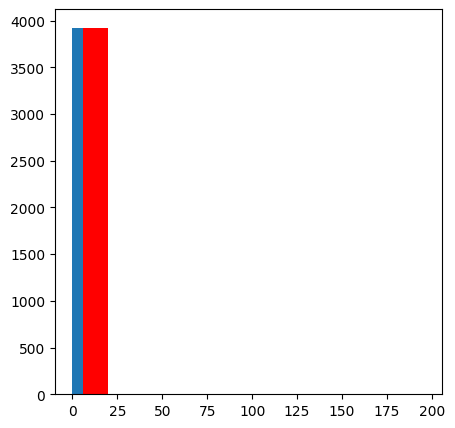

In [156]:
plt.figure(figsize=(5, 5))
control_revenue_all = data['REVENUE'][data['VARIANT_NAME']=='control']
test_revenue_all = data['REVENUE'][data['VARIANT_NAME']=='variant']


plt.hist(control_revenue_all, color='r')
plt.hist(test_revenue_all)


plt.show()

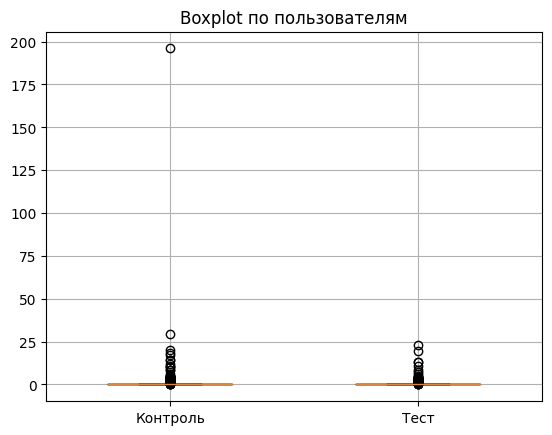

In [157]:
plt.boxplot([control.REVENUE,test.REVENUE],
            labels=['Контроль','Тест'],
            widths=0.5
           )
plt.title('Boxplot по пользователям',  loc='center')
plt.grid(axis  ='both')

In [126]:
stats.ttest_ind(control.REVENUE.values, test.REVENUE.values, equal_var = False)

TtestResult(statistic=1.0500711418412234, pvalue=0.2938145266921278, df=1965.0512867317032)

##Расчет мощности



In [158]:
C_mean = control.REVENUE.values.mean()

T_mean = test.REVENUE.values.mean()


C_std = control.REVENUE.values.std()

T_std = test.REVENUE.values.std()
print(len(control.REVENUE.values), len(test.REVENUE.values))

2390 2393


In [159]:
n = len(control.REVENUE.values)

S = np.sqrt((T_std**2 +C_std**2)/2)

ef = float((C_mean-T_mean)/S)


In [160]:
alpha = 0.05
analysis = TTestIndPower()
analysis = sm.stats.power.TTestIndPower()
result = analysis.solve_power(ef, power=None,
                              nobs1=n, ratio=1.0, alpha=alpha)

result

0.28803096229144043

Низкая статистическая мощность: большой риск совершения ошибок типа II, необходимо пересмотреть дизайн АВ теста и запустить его заново.